<a href="https://colab.research.google.com/github/sarnavadatta/Finance-in-Python/blob/main/VolatilityPrediction_GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from arch import arch_model
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import stock data
df = yf.download("HDFCBANK.NS", start="2018-01-01", end="2025-06-30")
df.columns = df.columns.get_level_values(0)

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,869.462280,881.769309,867.586924,877.995131,3290258
2018-01-02,877.830994,879.073429,871.361048,871.361048,2388158
2018-01-03,868.594849,880.597119,867.914998,879.073392,2265644
2018-01-04,871.994080,874.619568,868.759078,868.759078,1186888
2018-01-05,873.728760,875.815129,869.954638,873.447468,1435434


In [ ]:
# calculate log returns
df['log_return'] = np.log(df['Close']).diff()
# Calculate percentage return
df['return'] = df['Close'].pct_change().dropna() * 100

# Estimate Realized Volatility (rolling 30-day std of log returns)
df['realized_vol'] = df['log_return'].rolling(window=30).std() * np.sqrt(252)
df.dropna(inplace=True)

df.head()

Price,Close,High,Low,Open,Volume,log_return,return,realized_vol
Date,,,,,,,,
2018-04-02,905.422241,907.555482,886.340509,886.340509,2298184,0.023630,2.391178,0.164850
2018-04-03,898.249023,902.843613,895.951700,902.023145,2039942,-0.007954,-0.792251,0.166771
2018-04-04,882.941406,902.491978,880.690955,896.865907,1857054,-0.017188,-1.704162,0.174482
2018-04-05,894.967163,897.358232,886.199836,891.403997,2429446,0.013528,1.362011,0.178772
2018-04-06,901.765259,903.195184,893.513701,896.514226,1860004,0.007567,0.759592,0.177994


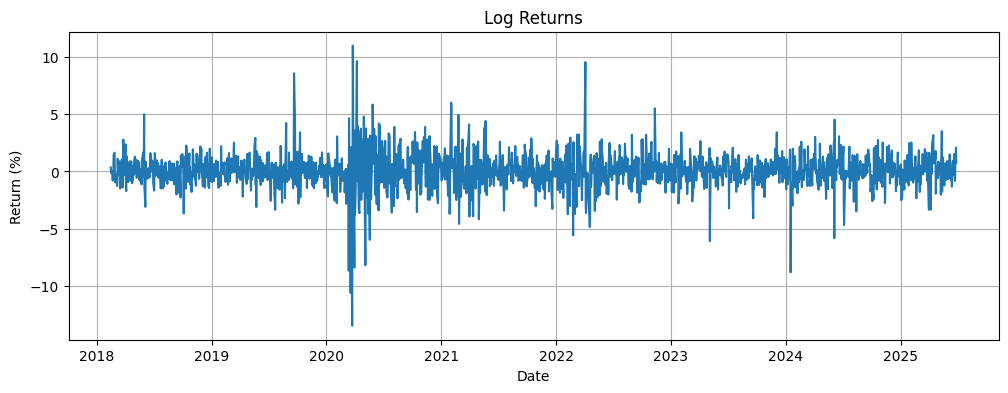

In [ ]:
returns = df['log_return'] * 100  # GARCH models prefer percentage scale
returns.dropna(inplace=True)
# Visualize Returns & Check for Volatility Clustering
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(returns)
plt.title('Log Returns')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.show()


In [ ]:
returns

,log_return
Date,
2018-02-14,0.345774
2018-02-15,-0.066415
2018-02-16,-0.175503
2018-02-19,-0.021298
2018-02-20,-0.801830
...,...
2025-06-23,-0.833100
2025-06-24,0.639504
2025-06-25,0.979429


In [ ]:
!pip install arch

In [ ]:
from arch import arch_model

# Fit GARCH(1,1) on returns
model = arch_model(returns, vol='GARCH', p=7, q=7, rescale=False)
res = model.fit(disp='off')
print(res.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3154.69
Distribution:                  Normal   AIC:                           6341.38
Method:            Maximum Likelihood   BIC:                           6429.47
                                        No. Observations:                 1819
Date:                Fri, Jul 25 2025   Df Residuals:                     1818
Time:                        11:26:56   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0247  3.476e-02      0.710      0.478 

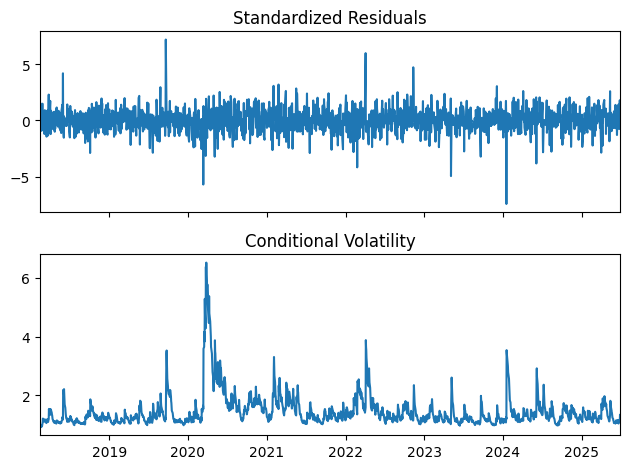

In [ ]:
res.plot()
plt.tight_layout()
plt.show()


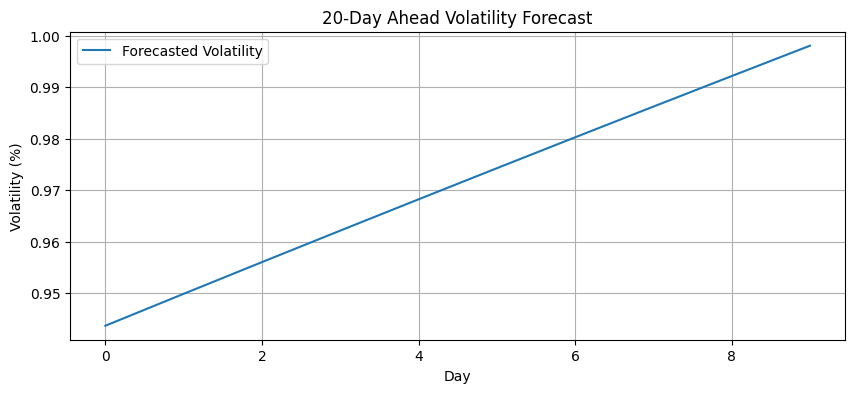

In [ ]:
horizon = 10  # forecast for 20 days
forecast = res.forecast(horizon=horizon)
volatility_forecast = np.sqrt(forecast.variance.values[-1, :])

# Plot forecasted volatility
plt.figure(figsize=(10, 4))
plt.plot(volatility_forecast, label='Forecasted Volatility')
plt.title('20-Day Ahead Volatility Forecast')
plt.xlabel('Day')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from itertools import product

# Select best GARCH(p,q) model via AIC using historical data
returns_pct = df['log_return'] * 100  # Convert to percent scale
train_data = returns_pct[:-30]  # Leave last 30 for rolling forecast


best_aic = np.inf
best_order = None
best_model = None

for p, q in product(range(1, 4), range(1, 4)):
    try:
        model = arch_model(train_data, vol='GARCH', p=p, q=q)
        res = model.fit(disp='off')
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = (p, q)
            best_model = res
    except:
        continue

print(f"Best GARCH order: {best_order}, AIC: {best_aic:.2f}")

Best GARCH order: (1, 1), AIC: 6184.47


In [ ]:
# Rolling 1-day-ahead prediction for next 30 days using previous 30 days
predicted_vol = []
forecast_dates = []

for i in range(30):
  start_idx = -30 - 30 + i  # Adjust index to keep rolling window
  end_idx = -30 + i
  train_window = returns_pct.iloc[start_idx:end_idx]

  model = arch_model(train_window, vol='GARCH', p=best_order[0], q=best_order[1])
  res = model.fit(disp='off')
  forecast = res.forecast(horizon=1)

  # Convert variance forecast to annualized std
  pred_std = np.sqrt(forecast.variance.values[-1, 0]) / 100 * np.sqrt(252)
  predicted_vol.append(pred_std)
  forecast_dates.append(df.index[end_idx])

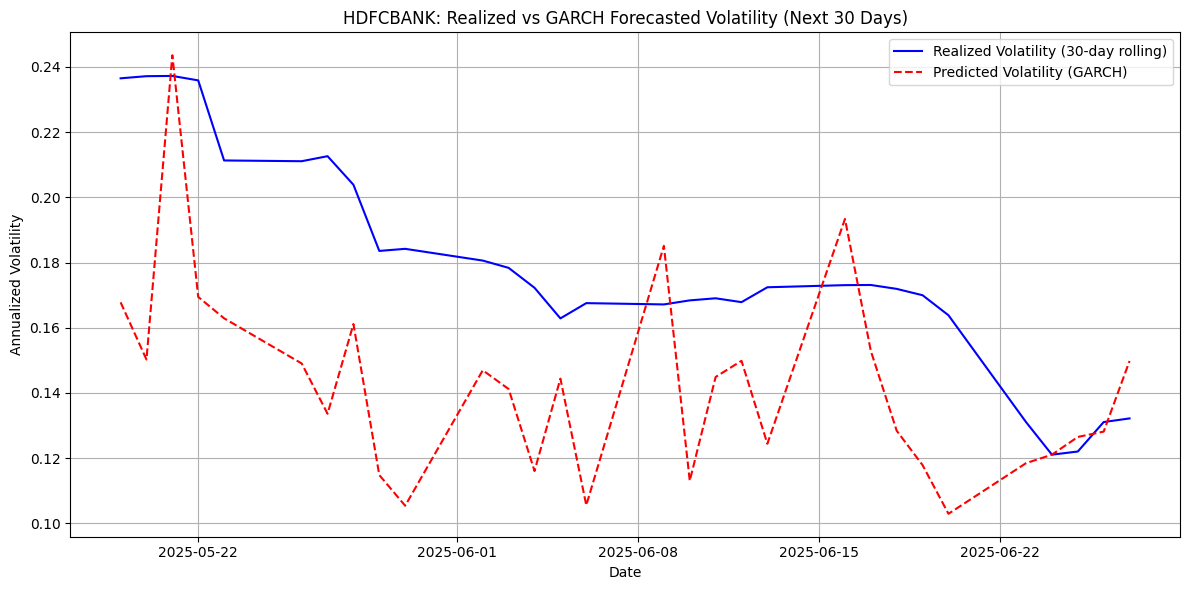

In [ ]:
realized_vol_plot = df['realized_vol'].loc[forecast_dates]

plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, realized_vol_plot, label='Realized Volatility (30-day rolling)', color='blue')
plt.plot(forecast_dates, predicted_vol, label='Predicted Volatility (GARCH)', color='red', linestyle='--')
plt.title('HDFCBANK: Realized vs GARCH Forecasted Volatility (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Using Feature transform (scaling the log returns)**

Best GARCH(p,q): (1, 1) with AIC: 18650.20


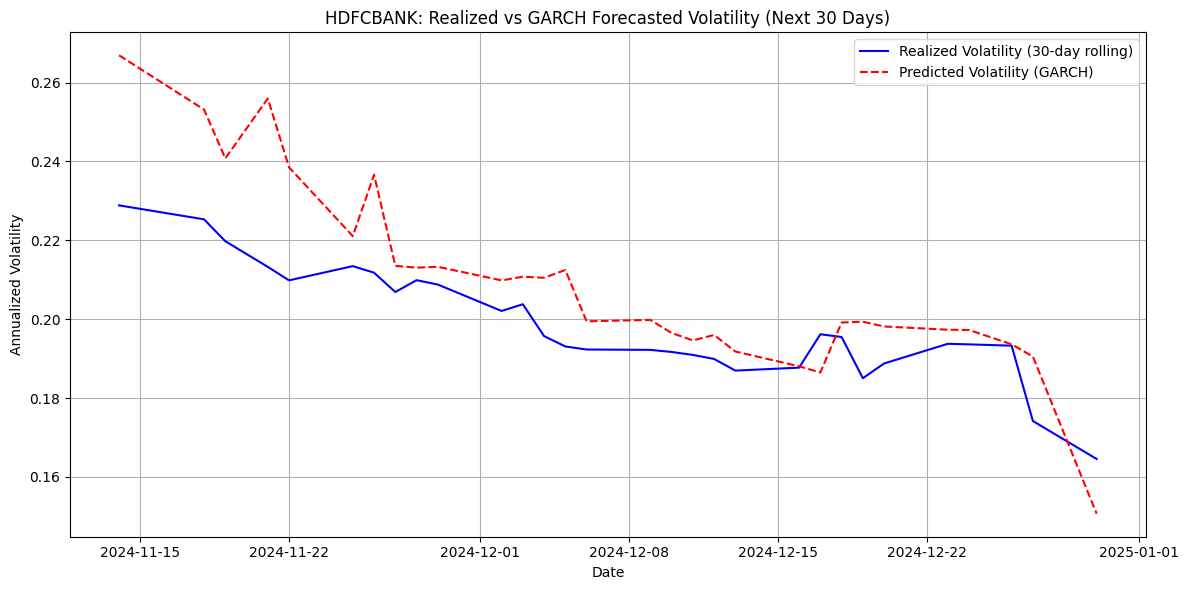

In [ ]:
# Scale log returns
scaler = StandardScaler()
df['scaled_return'] = scaler.fit_transform(df[['log_return']])

# Compute realized volatility (30-day rolling window, annualized)
window_size = 30
df['realized_vol'] = df['log_return'].rolling(window=window_size).std() * np.sqrt(252)
df.dropna(inplace=True)

# Select best GARCH(p,q) based on AIC using training data
train_data = df['scaled_return'][:-30] * 100  # GARCH prefers percentage scale

best_aic = np.inf
best_order = None

for p, q in product(range(1, 3), range(1, 3)):
    try:
        model = arch_model(train_data, vol='GARCH', p=p, q=q)
        res = model.fit(disp='off')
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = (p, q)
    except:
        continue

print(f"Best GARCH(p,q): {best_order} with AIC: {best_aic:.2f}")

# Rolling forecast for next 30 days (1-step ahead each time)
predicted_vol = []
forecast_dates = []

scaled_returns = df['scaled_return'] * 100  # scale up again

for i in range(30):
    train_window = scaled_returns.iloc[-60 - 30 + i : -30 + i]  # 30-day rolling window
    model = arch_model(train_window, vol='GARCH', p=best_order[0], q=best_order[1])
    res = model.fit(disp='off')
    forecast = res.forecast(horizon=1)

    # Convert to unscaled annualized volatility
    pred_std_scaled = np.sqrt(forecast.variance.values[-1, 0])
    pred_std_unscaled = pred_std_scaled / 100 * scaler.scale_[0] * np.sqrt(252)

    predicted_vol.append(pred_std_unscaled)
    forecast_dates.append(df.index[-30 + i])

# Get realized volatility for same dates
real_vol = df.loc[forecast_dates, 'realized_vol']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, real_vol, label='Realized Volatility (30-day rolling)', color='blue')
plt.plot(forecast_dates, predicted_vol, label='Predicted Volatility (GARCH)', color='red', linestyle='--')
plt.title('HDFCBANK: Realized vs GARCH Forecasted Volatility (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
